# Water Puzzle Solving Using Q-Learning

### Brief Introduction
As soon as I started playing the water puzzle game, I quickly learnt that I myself was not good at it. However, instead of an early retirement from the game, I decided to rely on my knowledge in reinforcement learning, and look into how to solve this problem using a RL algorithm.

### The Water Puzzle
Given vials containing water of different colours (as seen in the image below), the vials are poured into one another until all the water is sorted by colour. This means each vial contains water of a single colour (or is empty). An additional rule to the game is that only the same color water can be poured onto each other. So for example, the first vial cannot be poured into the third, but can be poured into the second.
<p style="text-align:center;"><img src="Water Puzzle Example 1.png" alt="Getting started" /></p>

### The Environment
To represent this problem programmatically I first needed representations of the state space and the action space. With these I could represent any given stage of the problem, as well as actions taken.
##### State & Action Spaces:
For the state space, I represented each vial as a list of integers representing the different colours in the puzzle, with the top of the vial corresponding to the last element in the list. Then the entire puzzle was represented by a larger list of these lists, one for each vial. Lists were used because they include the list.pop() and list.append() method, which allows for numbers to easile be moved from one vial to another. So in the case of the image above, the state of the puzzle would be given as [ [1,2,1,2] [1,2,1], [2] ]. The action space for a given state is represented as a list of tuples (from_vial, to_vial) which indicates which vial will be poured and into which vial.
##### Environment:
To create the environment, I created a class **environment**, which had functions built in to do the following:
<li> hash_state: This function creates a string representation of the vials, which is then used as a key for the Q-table dictionary, or to verify if a state has been previously reached.
<li> get_actions: This function takes a state, and returns a list containing tuples representing valid actions (the action space)
<li> take action: This function performs a given (valid) action, pouring a vial until another colour is seen, or the vial being poured into is full.
<li> is_done: This function returns  a done flag and a goal flag for if the puzzle has reached a terminal state, upon which the trial or episode ends. A terminal state was defined as a solved puzzle (goal and done), or a state which has been previously experienced is reached again. Performing this step in particular is done to achieve a shorter number of steps in the solution.
<li> reset: This function returns the environment to its original state, and resets the goal and done flags.
<li> step: This function takes an action, and returns a new state, a reward, and  flags indicating if an episode is terminated and/or in the goal state

<br>
<br>

### The Algorithm
The algorithm used was a Q-Learning algorithm. An off-policy learning method was used because given a certain number of vials and colours, the number of possible states is entirely determined.  Using an off-policy method encourages the agent to continue exploring, as this opens the possibility of a quicker solution being discovered. If a on-policy learner was used (Such as SARSA), the agent would base actions takens entirely on prior knowledge, which could lead to exploring dead ends that appear to be solutions, or sub optimal solutions entirely. For the Q-table, instead of using a dataframe with the entire state space mapped out (combinations of all the vials), a default dictionary was used. This allows for a Q-table that can be easily queried by state, while reducing the size of the table to only experienced states, saving memory.

<br>
<br>

### The Solution
After tuning the learning rate ($\alpha$), discount factor ($\gamma$) and the probability of taking a random action ($\epsilon$), the reinforcement learning agent was able to sole the environment pictured below in about 15,000 episodes (total runtime of 1:14 mins).

### Libraries

In [69]:
#import libraries
import pandas as pd
import numpy as np
import collections
from copy import deepcopy
from collections import defaultdict
from tqdm import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from IPython.display import Image

In [2]:
#default function for default dictionary
def default():
    return('None')

### Create Environment Class

In [3]:
class environment:
    def __init__(self, vials = [[],[ 1,  2,  3,  4],[1,  2,  3,  4],[1,  2,  3 ],[4],[1,  2,  3,  4]]):
        self.starting_vials = vials
        self.n_vials = len(self.starting_vials)
        self.state = deepcopy(self.starting_vials)
        self.state_list = [self.hash_state()]
        self.MAX_COLOURS = 4


    def hash_state(self):
        '''
        Given a congfiguration of the vials, turn it to a string
        Input: Vials (list of lists)
        Output: String
        '''
        key = ''
        for vial in self.state:
            if not vial:
                key += '-'
            else:
                for col in vial:
                    key += str(col)
            key += '/'
        return(key)
        
# Create starting vials

    def step(self, action):
        ''' 
        Given a tuple indicating the action (from_vial, to_vial), take the action, and provide a reward on the successor state.
        Also. sends values to indicate if a prior state has been reached (done), or if the goal state has been reached as well (goal).
        Returns:
        1) self.state: the resulting (successor) state
        2) Reward: 100 if a goal state is reached, -10 if a terminal state is reached but not the goal, and -1 if an action is taken that is neither terminal or the goal state
        3) Done: Returns True if a terminal state is reached
        4) Goal: Returns True if the goal state is reached
        '''

        #Take Action
        self.take_action(action)
        # Check if it is done or goal and give corresponding reward
        done, goal = self.is_done()
        
        if(done and goal):
            reward = 100
        elif(done and not goal):
            reward = -10
        else:
            reward = -1
                    
        return (self.state, reward, done, goal)
    
    def is_done(self):
        ''' 
        If a state is being repeated it is assumed the algorithm is no closer to the solution, and the done flag is raised
        if the resulting state is sorted vials, then the goal flag is raised
        Returns:
            1) Boolean flag for episode marked as done
            2) Boolean flag for episode marked as goal
        '''
        
        if (not self.get_actions()):
            is_done = True
        else:
            is_done = False
        # Check for goal flag
        vial_check = []
        
        for idx, vial in enumerate(self.state):
            
            # Vial is empty
            if (not vial):
                vial_check.append(1)
            elif(len(set(vial)) == 1 and len(vial) == self.MAX_COLOURS):
                vial_check.append(1)
            else:
                vial_check.append(0)
                
        if(sum(vial_check)==self.n_vials):
            is_goal = True
            is_done = True
        else:
            is_goal = False
            
        return(is_done, is_goal)
    
    def reset(self):
        '''
        This function resets the environemnt back to the original state
        '''
        self.state = deepcopy(self.starting_vials)
        self.state_list = [self.hash_state()]
        return(None)
        
    def take_action(self, action):
        ''' 
        Given a tuple indicating the action (from_vial, to_vial), take the last value of the vial indexes by from_vial and append it to the vial indexed by to_vial.
        This function will then hash the new state and add it to the list of states for th environemnt, then return the new state
        Returns: key of resulting state (string of vials)
        '''
        pour_conditions = True
        while(len(self.state[action[1]]) < self.MAX_COLOURS and pour_conditions):
            value_to_move = self.state[action[0]].pop()
            if(not self.state[action[0]]):
                pour_conditions = False
            elif(self.state[action[0]][-1] != value_to_move):
                pour_conditions = False
            else:
                pour_conditions = True
            self.state[action[1]].append(value_to_move)
        key = self.hash_state()
        self.state_list.append(key)
        return()
        
        
        
    def get_actions(self):
        '''
        Given a state of the environemnt, return a list of tuples containing which moves are valid (pours from a vial to another) indexed by 0
        Returns: List of action tuples (from_vial, to_vial)
        '''
        possible_vials = []
        actions = []
        for idx, vial in enumerate(self.state):
            if(not vial):
                continue
            else:
                value_to_match = vial[-1]

            for other_idx, other_vial in enumerate(self.state):
                # If same vial, continue
                if other_idx == idx:
                    continue
                # if other vial is empty it is valid,
                elif(not other_vial):
                    actions.append((idx,other_idx))
                # else if not full, match in last colour, it is valid
                elif(other_vial[-1] == value_to_match and len(other_vial) < self.MAX_COLOURS):
                    actions.append((idx,other_idx))
                else:
                    continue
                
        return(actions)

### Create Policy Functions

In [4]:
def epsilon_greedy(action_values, epsilon = 0.2):
    '''
    Given a numpy array action_values, return the index of a random action with probability epsilon (explore), or the index of the max with probability 1-epsilon (exploit)
    Returns: Index of an action in the action_values
    '''
    flag = ''
    n_actions = len(action_values)
    if random.uniform(0, 1) < epsilon:
        """
        Explore: select a random action
        """
        idx = random.sample(range(n_actions),1)
        flag = 'Explore'
    else:
        """
        Exploit: select the action with max value (future reward)
        (if multiple max values randomly choose from them)
        """
        idx = random.sample(np.where(action_values == action_values.max())[0].tolist(),1)
        flag = 'Exploit'
    return(idx[0], flag)

def softmax(action_values, epsilon):
    '''
    This function turn the action values into a vector of probabilities summing to one, and randomly (uniformly) samples from that vector
    Returns: index of choice, based on probability
    ''' 
    flag = 'Softmax'
    """Compute softmax values for each sets of scores in x."""
    probability_vector = np.exp(action_values) / np.sum(np.exp(action_values), axis=0)
    idx = np.random.choice(a= range(len(probability_vector)), p = probability_vector)
    return(idx, flag)




### Create Function to run Q-Learning Agent

In [5]:
def Q_Learning_Agent(env, n_episodes, alpha, gamma, epsilon, max_steps, window, policy = epsilon_greedy):
    wins = pd.DataFrame()
    Q_table = {}
    for i in tqdm(range(n_episodes)):
        env.reset()
        done = False
        goal = False
        #print(f"EPISODE {i}, prev num steps: {num_steps}")
        num_steps = 0
        if(i <= (n_episodes/4)):
            EPSILON = 0.5
        elif(i <= (n_episodes/2)):
            EPSILON = 0.25
        elif(i <= (n_episodes - (n_episodes/2))):
            EPSILON = 0.125
        elif(i <= (n_episodes - (n_episodes/4))):
            EPSILON = 0.01
        else:
            EPSILON = 0
            
        while(not done and num_steps<= max_steps):
            num_steps += 1
            # hash a the state and get possible actions
            key = env.hash_state()
            action_space = env.get_actions()
            # If state does not exist create new entry in Q_table based on action space length and sample it otherwise sample right away
            try:
                action_space_values = Q_table[key]
            except:
                Q_table[key] = np.zeros(len(action_space))
                action_space_values = Q_table[key]
             
            action_index, flag_chosen = policy(Q_table[key], epsilon)

            # Pick the action after sampling with epsilon-greedy
            action = action_space[action_index]

            # Take action, and observe reward and resulting state
            next_state, reward, done, goal = env.step(action)

            # Hash next state for indexing
            key_next_state = env.hash_state()

            # Create rows of zero if state is previously undiscovered
            try:
                next_state_values = Q_table[key_next_state]
            except:
                Q_table[key_next_state] = np.zeros(len(env.get_actions()))
                next_state_values = Q_table[key_next_state]

            try:
                max_next_state = Q_table[key_next_state].max()
            except:
                max_next_state = -10
                
            Q_table[key][action_index] += alpha * (reward + (gamma * max_next_state) -  Q_table[key][action_index])

        wins.loc[i,'Step Count'] = num_steps

        if(goal):
            
            wins.loc[i,'Result'] = 1
        else:
            wins.loc[i,'Result'] = 0
        wins['Rolling'] =  wins.Result.rolling(window).mean()
    return(Q_table, wins)


### Create & Validate Sample Environemnts

In [18]:
# Create sample environments
test_vials = [[],[ 1,  5,  3,  4],[1,  2,  5,  5],[5,  2,  3, 4],[2,3,4,1],[],[1,  2,  3,  4]]
test_vials2 = [[],[ 1,  1,  1, 3],[2,  2,  2,3],[1,  2,  3, 3],[],]
test_vials3 = [[2],[ 1,  1,  1, 1],[2,  2,  2],[]]
test_vials4 = [[1,2,2,3],[4,5,6,7],[3,1,3,6],[1,5,5,6],[7,1,4,4],[2,2,7,3],[7,6,4,5],[],[]]


In [19]:
# Validating the vials by checking to see that all digits occur 4 times in the lists
all_vials = []
for vial in test_vials4:
    all_vials += vial

arr = np.array(all_vials)
for x in range(1,len(set(all_vials)) +1,1):
    print(f"{x}: {len(np.where(arr == x)[0])}")

1: 4
2: 4
3: 4
4: 4
5: 4
6: 4
7: 4


### Initial Testing of model

In [67]:
N_EPISODES = 50000
ALPHA = 0.95
GAMMA = 0.75
EPSILON = 0.2
MAX_STEPS = 100
WINDOW_SIZE = int(N_EPISODES/50)

env = environment(vials = test_vials4)
Q_Table, result_df = Q_Learning_Agent(env, n_episodes = N_EPISODES, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON, max_steps = MAX_STEPS, window = WINDOW_SIZE, policy = epsilon_greedy)

100%|██████████| 50000/50000 [03:08<00:00, 264.61it/s]


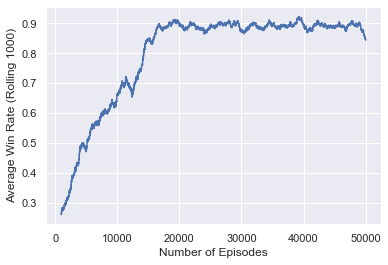

In [70]:
fig = sns.lineplot(data=result_df, x= range(N_EPISODES), y = 'Rolling')
plt.xlabel("Number of Episodes")
plt.ylabel(f"Average Win Rate (Rolling {WINDOW_SIZE})")
plt.show()

Using an epsilon-greedy policy, the RL agent was able to achieve a win rate > 90% at about 18000 episodes, which shows it was able to successfuly solve the environment. The fact that the agent was unable to acheive a consistent win rate, as well as saw a drop in the win rate from ~90% back to 80% is due to the fact that epsilon was fixed at 0.2, meaning the agent took a random action 20% of the time. The benefit of this was that given more episodes, the agent might be able to find a more optimal solution through a random action. A disadvantage of this however is that in later stages of learning (especially when the entire state space has been assesed), the agent is still inconsistent from epsiode to episode. Tuning the epsilon to curb this behavior will be evaluated in later stages.

## Tuning Parameters and Policy

###  Effect of Different Values of Epsilon
In this section, the effect of using the softmax action selection method, which quantizes the action values for a given state to a probabilies that sum up to one, is evaluated against the epsilon greedy function set to different values of epsilon. The different values of epsilon also consider the case of a greedy agent, which only selects the best possible action for a given state

In [35]:
EPSILON_VALUES = [0,0.1,0.15,0.2]
ALPHA = 0.95
GAMMA = 0.75

final_df = pd.DataFrame()
final_df['Index'] = range(N_EPISODES)
step_count_df = pd.DataFrame()
step_count_df['Index'] = range(N_EPISODES)
for EPSILON in EPSILON_VALUES:
    col_name = f"Epsilon: {str(EPSILON)}"
    Q_Table, result_df = Q_Learning_Agent(env, n_episodes = N_EPISODES, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON, max_steps = MAX_STEPS, window = WINDOW_SIZE, policy = epsilon_greedy)
    final_df[col_name] = result_df['Rolling']
    step_count_df[col_name] = result_df['Step Count']
# Test softmax
Q_Table, result_df = Q_Learning_Agent(env, n_episodes = N_EPISODES, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON, max_steps = MAX_STEPS, window = WINDOW_SIZE, policy = softmax)
final_df["Softmax"] = result_df['Rolling']
step_count_df["Softmax"] = result_df['Step Count']



100%|██████████| 50000/50000 [05:06<00:00, 163.07it/s]


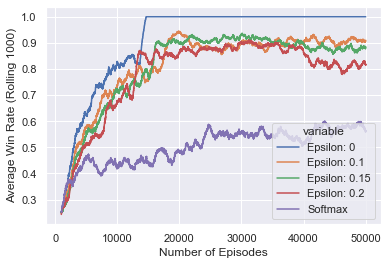

In [53]:
final_df_epsilon = final_df.melt(id_vars=['Index'], value_vars = ['Epsilon: 0', 'Epsilon: 0.1', 'Epsilon: 0.15', 'Epsilon: 0.2', 'Softmax'], value_name ='Rolling Average')
fig = sns.lineplot(data=final_df_epsilon, x= 'Index', y = 'Rolling Average', hue = 'variable')
plt.xlabel("Number of Episodes")
plt.ylabel(f"Average Win Rate (Rolling {WINDOW_SIZE})")
plt.show()

From testing the agent in the environment, it appears that the greedy (epsilon = 0) agent had the best performance. The win rate of the agent converges very quickly, and also achieves a win rate of 1 after ~15000 episodes, which indicates that the agent has reached a solution (regardless of if this solution is optimal). It is also important to note that as the number of episodes incresases, the softmax agent should appraoch the greedy agent, as the action values for states leading up to the solution are updated with higher reward values, which will in turn make the softmax quantized value approach 0.99 for those actions. Based on the performances of different values of epsilon, the greedy agent was used.

##  Effect of Different Values of the Learning Rate ($\alpha$)

In [54]:
ALPHA_VALUES = [0.9,0.925,0.95,0.975]
EPSILON = 0
GAMMA = 0.75

melt_columns = []
final_df = pd.DataFrame()
final_df['Index'] = range(N_EPISODES)
step_count_df = pd.DataFrame()
step_count_df['Index'] = range(N_EPISODES)
for ALPHA in ALPHA_VALUES:
    col_name = f"ALPHA: {str(ALPHA)}"
    melt_columns.append(col_name)
    Q_Table, result_df = Q_Learning_Agent(env, n_episodes = N_EPISODES, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON, max_steps = MAX_STEPS, window = WINDOW_SIZE, policy = epsilon_greedy)
    final_df[col_name] = result_df['Rolling']
    step_count_df[col_name] = result_df['Step Count']

100%|██████████| 50000/50000 [02:35<00:00, 322.47it/s]


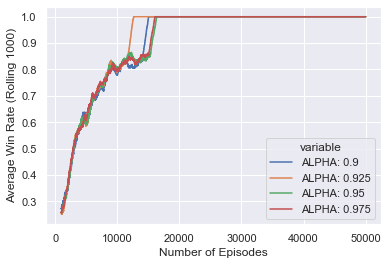

In [55]:
final_df_alpha = final_df.melt(id_vars=['Index'], value_vars = melt_columns, value_name ='Rolling Average')
fig = sns.lineplot(data=final_df_alpha, x= 'Index', y = 'Rolling Average', hue = 'variable')
plt.xlabel("Number of Episodes")
plt.ylabel(f"Average Win Rate (Rolling {WINDOW_SIZE})")
plt.show()

As the agent completes episodes, the Q table is queried for state-action values of successor states, which will have been encountered in prior episodes. The state-action value for the given state and action is then updated according to the expression:
$$Q(s,a) = Q(s,a) + \alpha \{reward + \gamma * max_{a'}(Q(s',a')) - Q(s-a) \}$$
In the equation, the value of the prior state-action is subtracted from the value of the best action in the new state, and then multiplied by the learning rate $\alpha$. This allows the agent to learn because the state-action value of a given state is updated with a value that is affected by what the value of being in the next state is, controlled by the magnitude of the learning rate. By setting the value to 0, the value of a state-action pair is controlled by the experienced reward only. By setting $\alpha$ close to 1, as in this case, the algorithm will affect the value of the state to inform whether the action leads to a more favourable state or not in the future, by using of the next state(s) seen in prior experiences.
From running different values of alpha, it was seen that the value of alpha that led to the best performance is $\alpha$ = 0.925

## Effect Of Different Values of Gamma

In [58]:
GAMMA_VALUES = [0.75,0.8,0.95,0.99]
EPSILON = 0
ALPHA = 0.925

melt_columns = []
final_df = pd.DataFrame()
final_df['Index'] = range(N_EPISODES)
step_count_df = pd.DataFrame()
step_count_df['Index'] = range(N_EPISODES)
for GAMMA in GAMMA_VALUES:
    col_name = f"GAMMA: {str(GAMMA)}"
    melt_columns.append(col_name)
    Q_Table, result_df = Q_Learning_Agent(env, n_episodes = N_EPISODES, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON, max_steps = MAX_STEPS, window = WINDOW_SIZE)
    final_df[col_name] = result_df['Rolling']
    step_count_df[col_name] = result_df['Step Count']

100%|██████████| 50000/50000 [02:39<00:00, 313.34it/s]


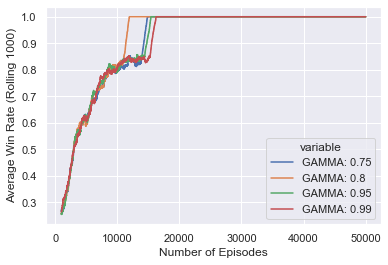

In [60]:
final_df_gamma = final_df.melt(id_vars=['Index'], value_vars = melt_columns, value_name ='Rolling Average')
fig = sns.lineplot(data=final_df_gamma, x= 'Index', y = 'Rolling Average', hue = 'variable')
plt.xlabel("Number of Episodes")
plt.ylabel(f"Average Win Rate (Rolling {WINDOW_SIZE})")
plt.show()

In the update equation provided in the previous section, $\gamma$ is multiplied by the best possible state-action value for the next state. This is done so that the total expected return for a given state converges. By tuning the discount factor $\gamma$ to a value between 0 and 1, the agent will weight the total expected return of a state rewards accordingly with 0 being that the expected total reward of a state is only the immediate reward. From using different (commonly used) values of $\gamma$, the best value for the agent was 0.8. 

## Final Testing

In [64]:
N_EPISODES = 20000
ALPHA = 0.925
GAMMA = 0.8
EPSILON = 0
MAX_STEPS = 100
WINDOW_SIZE = int(N_EPISODES/50)

env = environment(vials = test_vials4)
Q_Table, result_df = Q_Learning_Agent(env, n_episodes = N_EPISODES, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON, max_steps = MAX_STEPS, window = WINDOW_SIZE, policy = epsilon_greedy)
final_df['Rolling'] = result_df['Rolling']
final_df['Step Count'] = result_df['Step Count']

100%|██████████| 20000/20000 [01:14<00:00, 267.62it/s]


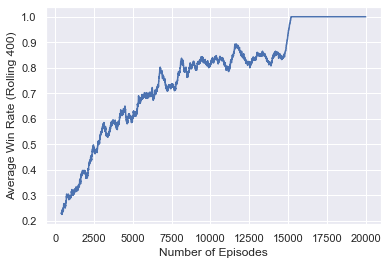

In [65]:
fig = sns.lineplot(data=final_df, x= 'Index', y = 'Rolling')
plt.xlabel("Number of Episodes")
plt.ylabel(f"Average Win Rate (Rolling {WINDOW_SIZE})")
plt.show()

From the final model, the agent was able to solve the environment at about 15,000 episodes. This is where we see the win rate spike to 100% as the greedy agent has discovered a path that provides the goal state, and has updated the state-action values accordingly. This is also seen in the plot below, where at around 15,000 episodes, the agent consistently implements roughly 20 actions to get to a goal state. This is  aslight improvement from the initial implementation of the model, with the final model using about 16% less episodes to achieve a solution.

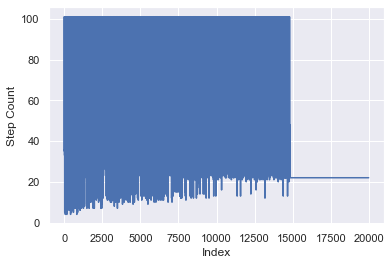

In [66]:
fig = sns.lineplot(data=final_df, x= 'Index', y = 'Step Count')